In [ ]:
# !pip install -Uq diffusers transformers fastcore

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [2]:
from transformers import CLIPTextModel, CLIPTokenizer

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to('cuda')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [4]:
from diffusers import AutoencoderKL, UNet2DConditionModel

In [5]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to('cuda')
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to('cuda')

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [6]:
from diffusers import LMSDiscreteScheduler

The plot below shows how betas (which represent how much noise is added at each timestep) evolves during the 1000 steps of the noising process used during training when using the k-LMS scheduler.

In general, the beta is high at later timesteps to achieve pure noise, and lower at earlier timesteps to add little noise and preserve the structure. Keep in mind, during training, we start at the later timestep and work toward timestep 0.

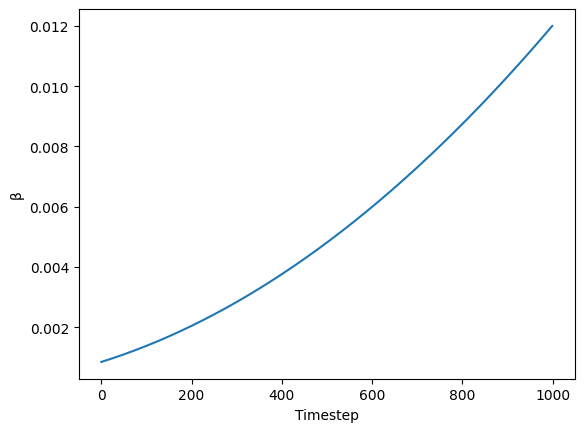

In [7]:
beta_start, beta_end = 0.00085, 0.012
plt.plot(torch.linspace(beta_start**0.5, beta_end**0.5, 1000)**2)
plt.xlabel('Timestep')
plt.ylabel('β');

In [8]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [9]:
prompt = ['a photograph of a kitten in a spaceship']

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [14]:
text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
print(len(text_input['input_ids'][0]))
text_input['input_ids']

77


tensor([[49406,   320,  8853,   539,   320, 13063,   530,   320, 34317, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

The ```input_ids``` are the tokens assigned to each component that the tokenizer has broken the prompt into. The max length is set to the tokenizer model's max length for textual input (in this case, 77). If the prompt is longer, it is truncated at 77, if it's shorter, padding is added with the ```<endoftext>``` token.

In [11]:
tokenizer.decode(49407)

'<|endoftext|>'

The attention mask places 1s where there are non-padding tokens and 0s where there are padding tokens. Notice, in addition to the tokens for the words in the prompt, there are 2 additional tokens that are added: start of sentence and end of sentence.

In [12]:
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

The text encoder will take each of these tokens and give us the associated embeddings. In this case, each embedding has dim of 768. Since we only have 1 prompt, the dim is ```[1,77,768]```.

In [15]:
text_embeddings = text_encoder(text_input.input_ids.to('cuda'))[0].half()
text_embeddings.shape

torch.Size([1, 77, 768])

To perform unconditional generation as part of classifier-free guidance, we need to generate ```uncond_embeddings``` that match the batch size (one for each prompt in a batch). As expected, they are identical in shape to the text_embeddings.

In [22]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding='max_length', max_length=max_length, return_tensors='pt')
uncond_embeddings = text_encoder(uncond_input.input_ids.to('cuda'))[0].half()
uncond_embeddings.shape

torch.Size([1, 77, 768])

For CFG, we need 2 forward passes--one with the ```uncond_embeddings``` and another with the ```text_embeddings```. Concatenating both into a single batch allows us to do both in a single forward pass.

In [24]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
text_embeddings.shape

torch.Size([2, 77, 768])

Then, we initalize our latents. We start from pure Gaussian (normal) noise:

In [26]:
latents = torch.randn((batch_size, unet.in_channels, height//8, width//8))
latents = latents.to('cuda').half()
latents.shape

/tmp/ipython-input-3752153720.py:1: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height//8, width//8))


torch.Size([1, 4, 64, 64])

The AE used in stable diffusion has a reduction factor of 8 but uses 4 channels instead of 3. Thus, we divide ```height``` and ```width``` by 8.

So an image the shape of (3,512,512) becomes (4,64,64) in latent space. Our initial latent has to be the same shape. The decoder will later transform this latent representation to the a ```3x512x512``` image after denoising process is complete.

Next, we initialize the scheduler with chosen ```num_inference_steps```. This prepares the internal state to be used during denoising.

In [27]:
scheduler.set_timesteps(num_inference_steps)

In [32]:
print(len(scheduler.timesteps))
scheduler.timesteps

70


tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3044, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9131, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0869, 260.6087, 246.1304, 231.6522, 217.1739, 202.6956,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3044, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000])

Here, our timesteps go from 999 to 0 (1000 steps that were used during training) in 70 steps following a particular schedule:

In [42]:
print(len(scheduler.sigmas))
scheduler.sigmas

71


tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7477,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

Scale the initial noise by the standard deviation required by the scheduler:

In [30]:
scheduler.init_noise_sigma

tensor(14.6146)

In [44]:
latents = latents * scheduler.init_noise_sigma

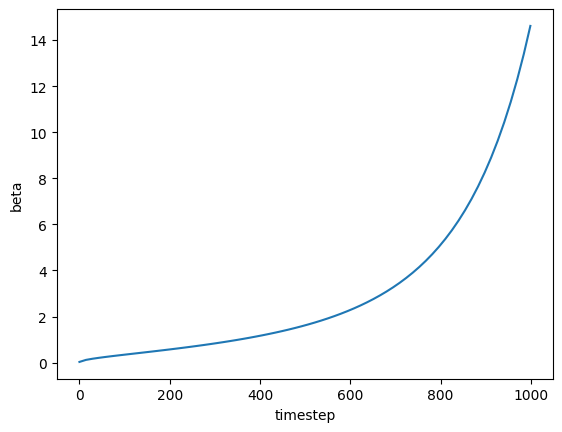

In [41]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]) # exclude sigma at ts=0
plt.xlabel('timestep')
plt.ylabel('beta');

In [43]:
from tqdm.auto import tqdm

In [48]:
for i,t in enumerate(tqdm(scheduler.timesteps)):
  input = torch.cat([latents] * 2)
  input = scheduler.scale_model_input(input,t)

  # predict the noise residual
  with torch.no_grad():
    pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  pred_uncond, pred_text = pred.chunk(2)
  pred = pred_uncond + guidance_scale*(pred_text - pred_uncond)

  # compute the "previous" noisy sample
  latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

Here, we are duplicating the latents--one each for ```uncond``` and ```text```--and concatenate them to represent as 1 batch of size 2. Then, the noise of the input is scaled according to sigma specified by scheduler at that timestep.

Prediction of the noise are made by unet. Note, unet generates a distribution of possible noise predicions, and we sample 1 from this distribution when we call ```.sample```.

```pred``` is unpacked into the pred generated when using the prompt vs with the uncond prompt. Then, CFG is performed by pushing ```pred_uncond``` more towards the ```pred_text```.

Finally, the scheduler updates the latents using the predicted noise. It computes the "previous" latent in the diffusion process (less noisy) i.e., stepping toward the clean image. "Previous" latent because it is going toward the earlier timesteps. ```prev_sample``` is the updated latent that becomes input for the next iteration.

At the end of the loop, ```latents``` contains the denoised representation of the iamge. Now, we can use the ```vae``` decoder to convert it back to pixel space.

In [49]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

The scaling of the latents here before sending them to the decoder is an important step.

During training, Stable Diffusion scales the latent space by a constant factor 0.18215 so that the variance of the latents is approximately 1. This helps training stability and normalization.

The U-Net is trained to work with latents that are scaled down by 0.18215.

So:

When encoding an image:
```python
latent = 0.18215 * VAE.encode(image)
```

When decoding a latent:
```python
image = VAE.decode(latent / 0.18215)
```

Again, the VAE produces a distribution of possible images, we sample 1 example from the distribution.

Then, we convert the image to PIL so that we can display it.

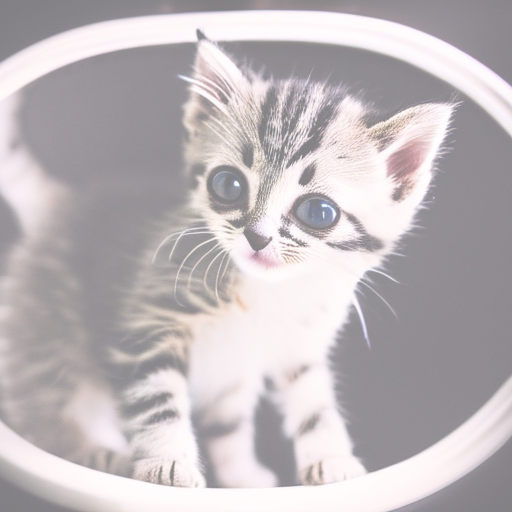

In [51]:
image = (image / 2 + 0.5).clamp(0,1)
image = image[0].detach().cpu().permute(1,2,0).numpy() # [C,H,W] → [H,W,C]
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

The first line here converts the image tensor from the ```[-1, 1]``` range to ```[0, 1]``` and clips any values outside that range.

The output from ```vae.decode(...)``` often has pixel values in the ```[-1, 1]``` range.

Most image libraries (like PIL, matplotlib, OpenCV) expect values in ```[0, 1]``` or ```[0, 255]``` for display or saving.

So this step ensures that the image is safe to visualize or convert to ```uint8```.